1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


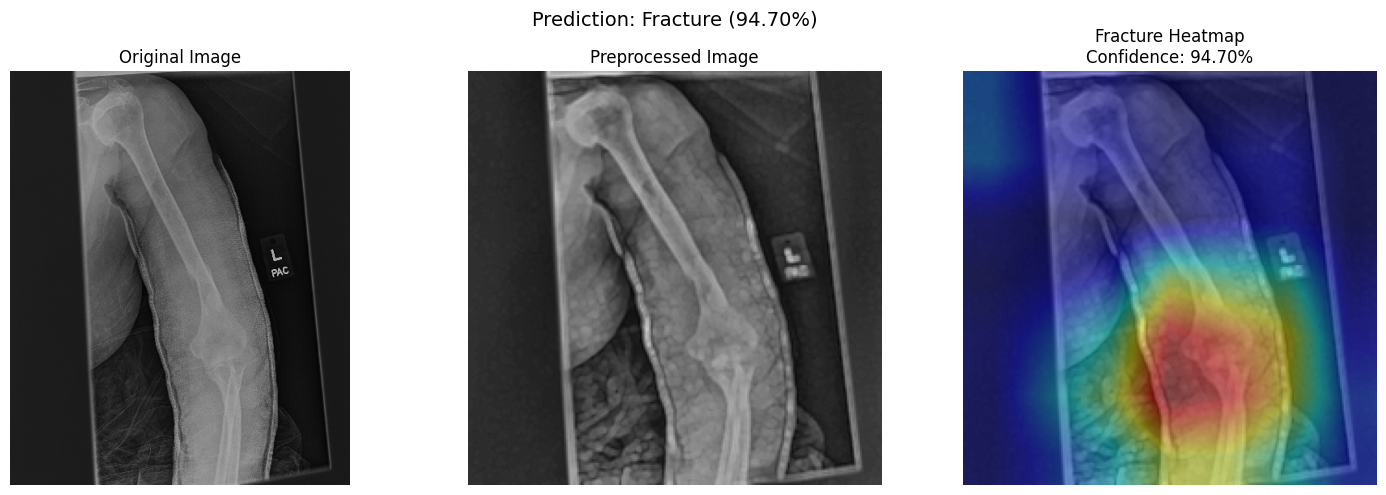


Prediction Results:
Diagnosis: Fracture
Confidence: 94.70%


In [3]:
# Required Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from skimage import exposure

# Configuration Dictionary
CONFIG = {
    'model_path': 'final_densenet_fracture_model.h5',
    'target_size': [224, 224],
    'visualize': True
}

# Load Trained Model
model = load_model(CONFIG['model_path'])

# Identify last conv layer for Grad-CAM (DenseNet121 specific)
LAST_CONV_LAYER_NAME = 'conv5_block16_2_conv'  # Update if different in your model

def preprocess_xray(img):
    """Enhance and preprocess an X-ray image."""
    img = exposure.adjust_gamma(img, gamma=0.7)
    img = cv2.GaussianBlur(img, (3, 3), 1)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    blurred = cv2.GaussianBlur(img, (5, 5), 2.0)
    img = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_map = np.sqrt(sobelx**2 + sobely**2)
    edge_map = cv2.normalize(edge_map, None, 0, 255, cv2.NORM_MINMAX)
    edge_map = cv2.cvtColor(edge_map.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(img, 0.7, edge_map, 0.3, 0)
    return img.astype(np.float32) / 255.0

def generate_gradcam(img, model, last_conv_layer_name):
    """Generate Grad-CAM heatmap."""
    img_tensor = np.expand_dims(img, axis=0)
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        predicted_class = tf.argmax(predictions[0])
        class_channel = predictions[:, predicted_class]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    return heatmap

def predict_fracture(image_path):
    """Predict fracture and optionally visualize."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
    original_img = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, tuple(CONFIG['target_size']))
    processed_img = preprocess_xray(img)
    input_tensor = np.expand_dims(processed_img, axis=0)

    # Predict
    prediction = model.predict(input_tensor)
    fracture_prob = prediction[0][0]
    result = "Fracture" if fracture_prob > 0.5 else "Normal"

    if CONFIG['visualize']:
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(original_img[..., ::-1])  # BGR to RGB
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(processed_img)
        plt.title("Preprocessed Image")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        if fracture_prob > 0.5:
            heatmap = generate_gradcam(processed_img, model, LAST_CONV_LAYER_NAME)
            heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            superimposed_img = cv2.addWeighted(
                cv2.cvtColor((processed_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR),
                0.6, heatmap_colored, 0.4, 0
            )
            plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Fracture Heatmap\nConfidence: {fracture_prob:.2%}")
        else:
            plt.imshow(processed_img)
            plt.title("No Fracture Detected")
        plt.axis('off')

        plt.suptitle(f"Prediction: {result} ({fracture_prob:.2%})", fontsize=14)
        plt.tight_layout()
        plt.show()

    return {
        'prediction': result,
        'probability': float(fracture_prob),
        'processed_image': processed_img
    }

if __name__ == "__main__":
    image_path = "image2.png"
    try:
        result = predict_fracture(image_path)
        print("\nPrediction Results:")
        print(f"Diagnosis: {result['prediction']}")
        print(f"Confidence: {result['probability']:.2%}")
    except Exception as e:
        print(f"Error: {str(e)}")
